In [1]:
import os
import json

from pathlib import Path
from collections import defaultdict, Counter
from itertools import chain, starmap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load Historic PSPS Data

In [2]:
source = pd.read_csv("../data/source.csv", parse_dates=["start", "end"])

### Load Weather Report data

In [3]:
wr = pd.read_csv("../loaders/mesowest/sce.csv", parse_dates=["Time", "Date"])
wr.head()

,Status,Mnet_Id,Elevation,Name,Elev_Dem,Longitude,State,Restricted,Qc_Flagged,Latitude,Timezone,Id,Period_Of_Record.Start,Period_Of_Record.End,Time,RelHum,WindSpd,GustSpd,Date,Station
0,ACTIVE,231,6388,SCE Marion Ridge,6400.9,-116.73432,CA,False,False,33.76594,America/Los_Angeles,70844,2018-06-11 20:11:00+00:00,2021-06-09 17:50:00+00:00,2021-01-12 00:00:00,30.89,2.87,6.43,2021-01-12,SE001
1,ACTIVE,231,6388,SCE Marion Ridge,6400.9,-116.73432,CA,False,False,33.76594,America/Los_Angeles,70844,2018-06-11 20:11:00+00:00,2021-06-09 17:50:00+00:00,2021-01-12 00:10:00,30.83,3.27,8.26,2021-01-12,SE001
2,ACTIVE,231,6388,SCE Marion Ridge,6400.9,-116.73432,CA,False,False,33.76594,America/Los_Angeles,70844,2018-06-11 20:11:00+00:00,2021-06-09 17:50:00+00:00,2021-01-12 00:20:00,31.16,2.16,6.06,2021-01-12,SE001
3,ACTIVE,231,6388,SCE Marion Ridge,6400.9,-116.73432,CA,False,False,33.76594,America/Los_Angeles,70844,2018-06-11 20:11:00+00:00,2021-06-09 17:50:00+00:00,2021-01-12 00:30:00,32.43,1.29,4.38,2021-01-12,SE001
4,ACTIVE,231,6388,SCE Marion Ridge,6400.9,-116.73432,CA,False,False,33.76594,America/Los_Angeles,70844,2018-06-11 20:11:00+00:00,2021-06-09 17:50:00+00:00,2021-01-12 00:40:00,32.18,1.32,3.58,2021-01-12,SE001


In [4]:
wr_dt_columns = ["Date", "Time"]
wr_ts_columns = ["RelHum", "WindSpd", "GustSpd"]
wr_cat_columns = ["Station"]
wr_cat_real_columns = ["Latitude", "Longitude"]
wr.columns

Index(['Status', 'Mnet_Id', 'Elevation', 'Name', 'Elev_Dem', 'Longitude',
       'State', 'Restricted', 'Qc_Flagged', 'Latitude', 'Timezone', 'Id',
       'Period_Of_Record.Start', 'Period_Of_Record.End', 'Time', 'RelHum',
       'WindSpd', 'GustSpd', 'Date', 'Station'],
      dtype='object')

In [5]:
wind_gust_perc = wr[["WindSpd", "GustSpd"]].describe(percentiles=np.arange(0,1,.01))[-10:]
wind_gust_perc

,WindSpd,GustSpd
91%,14.91,26.96
92%,15.66,28.12
93%,16.51,29.37
94%,17.45,30.83
95%,18.61,32.44
96%,20.01,34.34
97%,21.81,36.74
98%,24.29,40.04
99%,28.12,45.23
max,70.64,98.90


In [6]:
hum_perc = wr["RelHum"].describe(percentiles=np.arange(0,1,.01))[4:15]
hum_perc

0%      0.88
1%      9.00
2%      9.97
3%     10.67
4%     11.22
5%     11.67
6%     12.05
7%     12.40
8%     12.73
9%     13.02
10%    13.31
Name: RelHum, dtype: float64

In [7]:
outliers = wr[(wr.WindSpd > wind_gust_perc.WindSpd["99%"]) & (wr.GustSpd > wind_gust_perc.GustSpd["99%"]) & (wr.RelHum < hum_perc["10%"])]

In [8]:
outliers.Id.unique()

array([ 71312,  72882,  88896,  89911,  89912,  92121, 108441, 125752,
       139780, 141651, 141652, 142942, 150331, 151178, 152233, 152320,
       152639, 152640, 152657, 152687, 156554, 156555])

### Visualizations by Station

In [9]:
stations = station_crossings.head().index
dates = se_dates.iloc[6:]
fig, ax = plt.subplots(len(stations)-2, 1,figsize=(24,20), sharey=True)
for (s, v_ax) in zip(stations, ax):
        wrs = wr[(wr.Station==s) & (wr.Date >= "2020-12-01")]
        wrs.set_index("Time", inplace=True)
        
        # For a single date range, narrow plot to that range
        if len(dates.index) == 2:
            wrs = wrs.loc[dates.start:dates.end]
            
        v_ax.plot(np.log(wrs["HlyWindSpd (MPH)"]), label="Wind Speed")
        
        v_ax.plot(np.log(wrs["HlyRelHum (%)"]), color="purple", label="Humidity")
        
        v_ax.set_title("{} - {} - Humidity and Wind Speed (log)".format(ws[ws.StationNbr == s].City.values[0],s))
        
        # For multiple date ranges, highlight relevant time
        if len(dates.index) > 2:
            for (start, end) in dates.values:
                v_ax.axvspan(start, end, color='red', alpha=0.25, label="PSPS Event {} to {}".format(pd.Timestamp(start).date(), pd.Timestamp(end).date()))

#         v_ax[1].hist(wrs["HlyWindSpd (MPH)"].diff(), bins=30)
#         v_ax[1].set_title("{} Wind Speed Increments".format(s))
            
#         v_ax[3].hist(wrs["HlyRelHum (%)"].diff(), bins=30)
#         v_ax[3].set_title("{} Humidity".format(s))

v_ax.legend(loc="lower left")
# plt.savefig("../images/wind_hum_log.png")


NameError: name 'station_crossings' is not defined

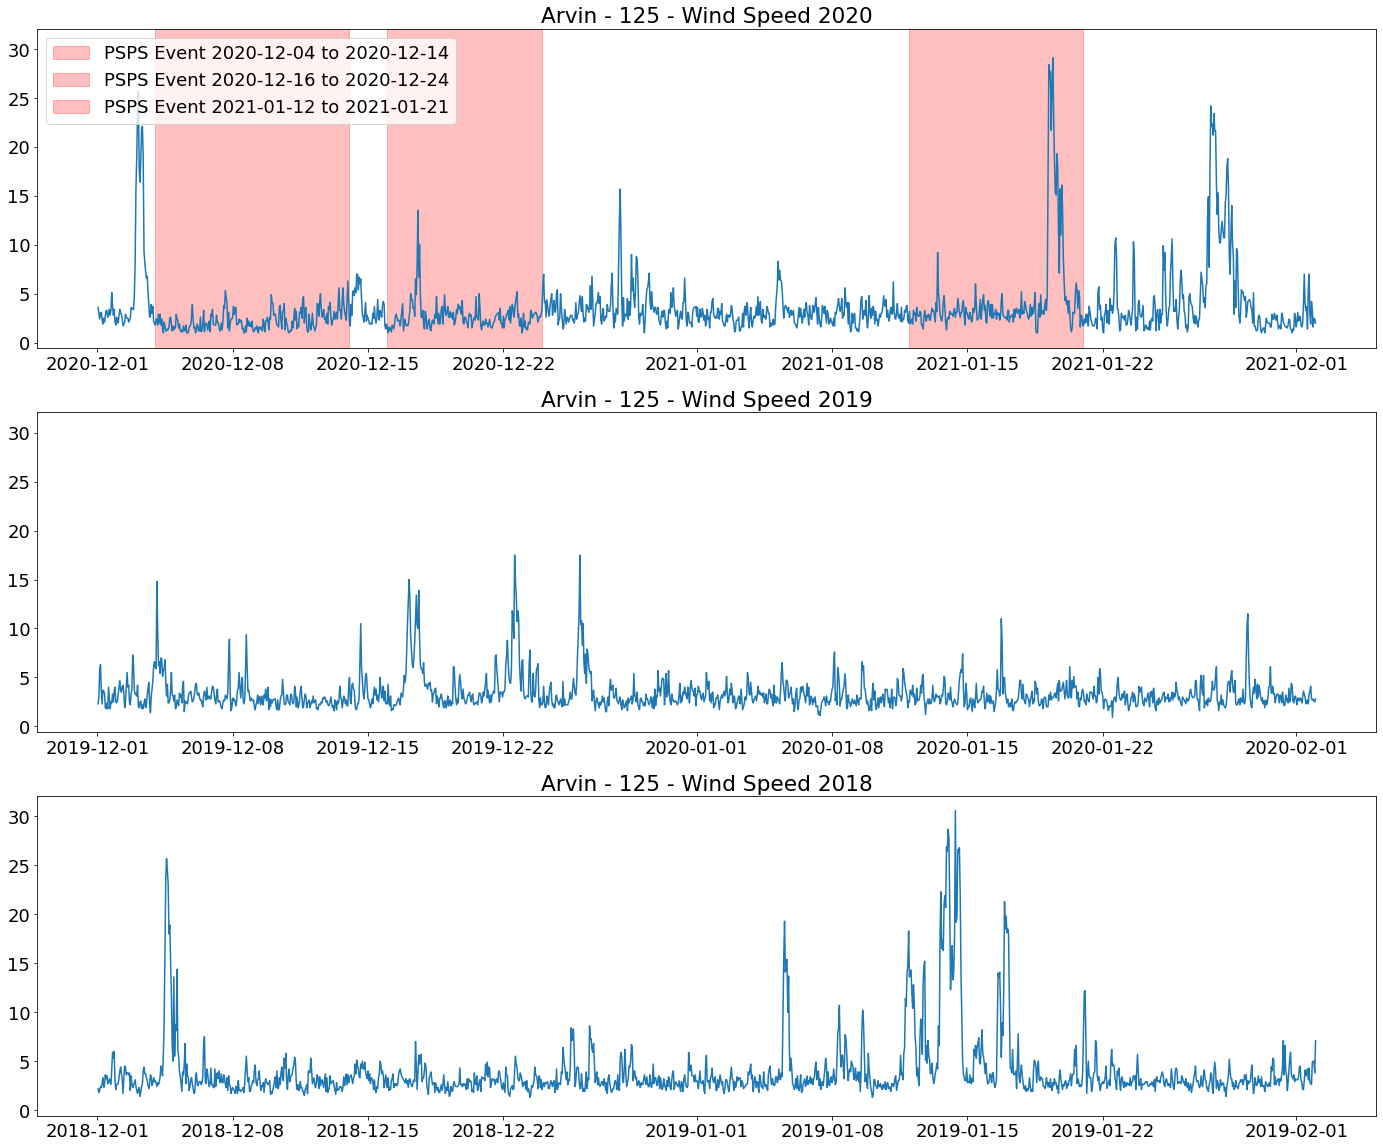

In [56]:
s = 125
wrs = wr[(wr.Station==s)].set_index("Time")

two_months = pd.Timedelta("62d")

fig, ax = plt.subplots(3, 1,figsize=(24,20), sharey=True)
for (year, v_ax) in zip(["2020", "2019", "2018"], ax): 
    start = pd.Timestamp("{}-12-01".format(year))
    end = start + two_months

    v_ax.plot((wrs.loc[(wrs.Date >= start) & (wrs.Date <= end),"HlyWindSpd (MPH)"]))

#     v_ax.plot((wrs.loc[(wrs.Date >= start) & (wrs.Date <= end),"HlyRelHum (%)"]), color="orange", label="Humidity")
    v_ax.set_title("{} - {} - Wind Speed {}".format(ws[ws.StationNbr == s].City.values[0],s, year))
    
    if year == "2020":
        for (start, end) in dates.values:
            v_ax.axvspan(start, end, color='red', alpha=0.25, label="PSPS Event {} to {}".format(pd.Timestamp(start).date(), pd.Timestamp(end).date()))
            v_ax.legend(loc="upper left")
            
        
#     For multiple date ranges, highlight relevant time
#     v_ax.axvspan("{}-12-01".format(year), "2021-01-21", color='red', alpha=0.25)

#     v_ax.legend(loc="upper left")
#     v_ax[1].hist(wrs["HlyWindSpd (MPH)"].diff(), bins=30)
#     v_ax[1].set_title("{} Wind Speed Increments".format(s))

#     v_ax[3].hist(wrs["HlyRelHum (%)"].diff(), bins=30)
#     v_ax[3].set_title("{} Humidity".format(s))
plt.savefig("../images/historic_wind.png")


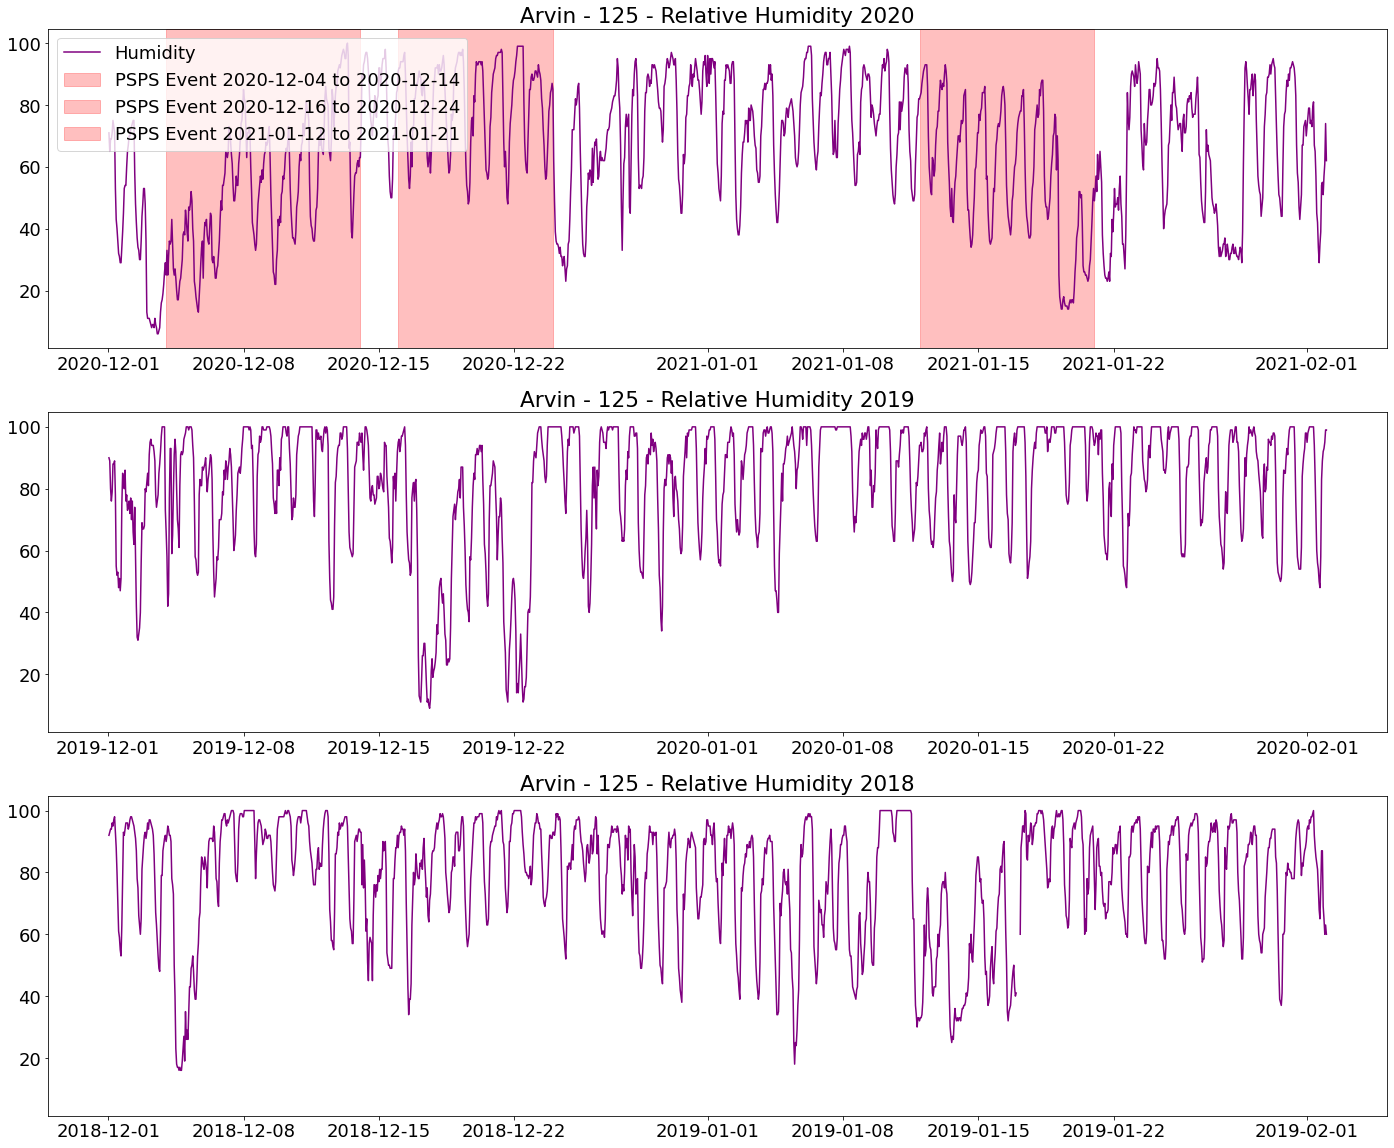

In [54]:
s = 125
wrs = wr[(wr.Station==s)].set_index("Time")

two_months = pd.Timedelta("62d")

fig, ax = plt.subplots(3, 1,figsize=(24,20), sharey=True)
for (year, v_ax) in zip(["2020", "2019", "2018"], ax): 
    start = pd.Timestamp("{}-12-01".format(year))
    end = start + two_months

#     v_ax.plot((wrs.loc[(wrs.Date >= start) & (wrs.Date <= end),"HlyWindSpd (MPH)"]))

    v_ax.plot((wrs.loc[(wrs.Date >= start) & (wrs.Date <= end),"HlyRelHum (%)"]), color="purple", label="Humidity")
    v_ax.set_title("{} - {} - Relative Humidity {}".format(ws[ws.StationNbr == s].City.values[0],s, year))
    
    if year == "2020":
        for (start, end) in dates.values:
            v_ax.axvspan(start, end, color='red', alpha=0.25, label="PSPS Event {} to {}".format(pd.Timestamp(start).date(), pd.Timestamp(end).date()))
            v_ax.legend(loc="upper left")
            
        
#     For multiple date ranges, highlight relevant time
#     v_ax.axvspan("{}-12-01".format(year), "2021-01-21", color='red', alpha=0.25)

#     v_ax.legend(loc="upper left")
#     v_ax[1].hist(wrs["HlyWindSpd (MPH)"].diff(), bins=30)
#     v_ax[1].set_title("{} Wind Speed Increments".format(s))

#     v_ax[3].hist(wrs["HlyRelHum (%)"].diff(), bins=30)
#     v_ax[3].set_title("{} Humidity".format(s))
plt.savefig("../images/historic_humidity.png")


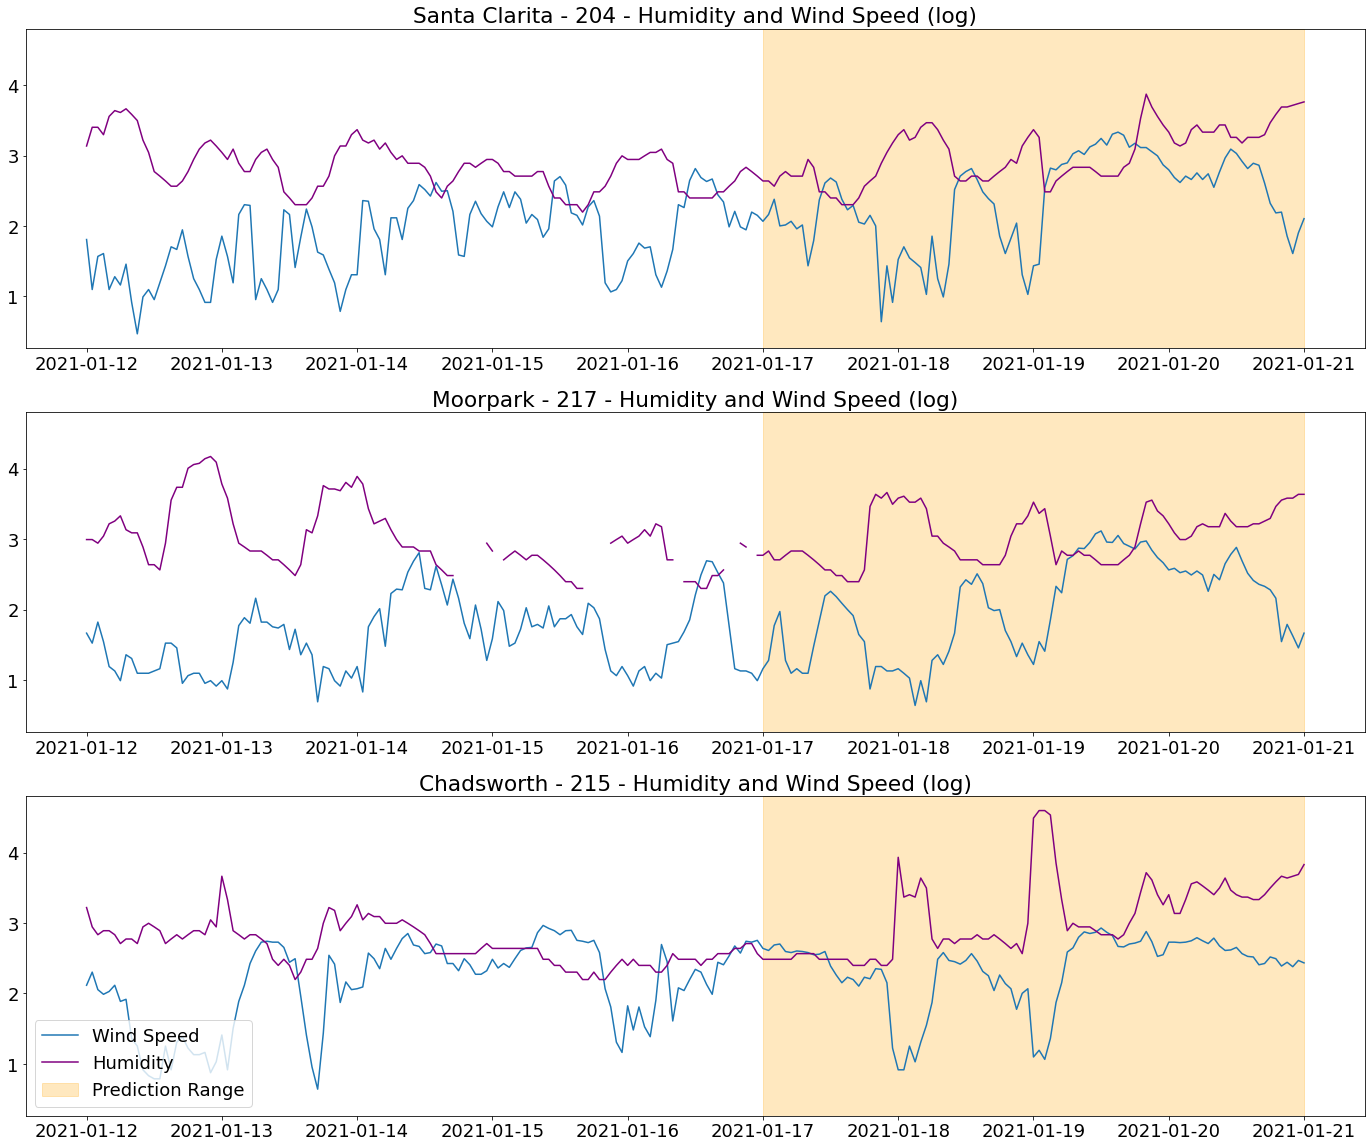

In [131]:
# 44, 219, 237
stations = [204, 217, 215]
dates = se_dates.iloc[8]
fig, ax = plt.subplots(len(stations), 1,figsize=(24,20), sharey=True)
for (s, v_ax) in zip(stations, ax):
        wrs = wr[(wr.Station==s) & (wr.Date >= "2020-12-01")]
        wrs.set_index("Time", inplace=True)
        
        # For a single date range, narrow plot to that range
        wrs = wrs.loc[dates.start:dates.end]
            
        v_ax.plot(np.log(wrs["HlyWindSpd (MPH)"]), label="Wind Speed")
        
        v_ax.plot(np.log(wrs["HlyRelHum (%)"]), color="purple", label="Humidity")
        
        v_ax.set_title("{} - {} - Humidity and Wind Speed (log)".format(ws[ws.StationNbr == s].City.values[0],s))
        
        # For multiple date ranges, highlight relevant time
        v_ax.axvspan("2021-01-17", end, color='orange', alpha=0.25, label="Prediction Range")

#         v_ax[1].hist(wrs["HlyWindSpd (MPH)"].diff(), bins=30)
#         v_ax[1].set_title("{} Wind Speed Increments".format(s))
            
#         v_ax[3].hist(wrs["HlyRelHum (%)"].diff(), bins=30)
#         v_ax[3].set_title("{} Humidity".format(s))

v_ax.legend(loc="lower left")
plt.savefig("../images/crossings_log.png")



## GlutonTS

In [10]:
from gluonts.mx.trainer import Trainer
from gluonts.model.predictor import Predictor
from gluonts.evaluation import make_evaluation_predictions
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import Evaluator

In [11]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.deepvar import DeepVAREstimator

In [66]:
wr_gts = wr.copy()
wr_gts.drop_duplicates(subset = ["Id"] + wr_ts_columns + wr_dt_columns, inplace=True)
wr_gts.set_index(["Time"], inplace=True)

In [67]:
# Filter out weather stations with < 7 days worth of data
wr_gts_id_counts = wr_gts.groupby("Id").count().RelHum
wr_gts_ids = wr_gts_id_counts[wr_gts_id_counts > 1008].index
wr_gts = wr_gts[wr_gts.Id.isin(wr_gts_ids)]

In [21]:
training_time_cutoff = "2021-01-19 00:00:00"
testing_time_cutoff = "2021-01-20 00:00:00"

In [22]:
single_datasets = []
for (station_id, df) in wr_gts.groupby("Id"):
    tss = df[wr_ts_columns].transpose().iterrows()
    for (c, ts) in tss:
        single_datasets.append({
            "item_id": "Training:  {} - {}".format(station_id, c),
            "start": ts.index[0],
            "target": ts.loc[:training_time_cutoff],
            "feat_static_cat": [station_id],
            "feat_static_real": [df[wr_cat_real_columns[0]].unique()[0], df[wr_cat_real_columns[1]].unique()[0]] #lat, long
        })

In [23]:
single_datasets[0]

{'item_id': 'Training:  70844 - RelHum',
 'start': Timestamp('2021-01-12 00:00:00'),
 'target': Time
 2021-01-12 00:00:00    30.89
 2021-01-12 00:10:00    30.83
 2021-01-12 00:20:00    31.16
 2021-01-12 00:30:00    32.43
 2021-01-12 00:40:00    32.18
                        ...  
 2021-01-18 23:20:00    21.12
 2021-01-18 23:30:00    21.28
 2021-01-18 23:40:00    21.44
 2021-01-18 23:50:00    21.83
 2021-01-19 00:00:00    22.28
 Name: RelHum, Length: 1009, dtype: float64,
 'feat_static_cat': [70844],
 'feat_static_real': [33.76594, -116.73432]}

In [24]:
all_single_training_data = ListDataset(
    single_datasets,
    freq = "10min",
)

In [25]:
next(iter(all_single_training_data))

{'item_id': 'Training:  70844 - RelHum',
 'start': Timestamp('2021-01-12 00:00:00', freq='10T'),
 'target': array([30.89, 30.83, 31.16, ..., 21.44, 21.83, 22.28], dtype=float32),
 'feat_static_cat': array([70844], dtype=int32),
 'feat_static_real': array([  33.76594, -116.73432], dtype=float32),
 'source': SourceContext(source='list_data', row=0)}

In [28]:
estimator = DeepAREstimator(
    freq="10min", 
    prediction_length=6*24, # 24-hour prediction
    trainer=Trainer(epochs=100, batch_size=32), 
    num_layers=20,
    use_feat_static_cat = True, cardinality = [wr.Id.unique().shape[0]], 
    use_feat_static_real = True,
)

### Train a new model...

In [29]:
predictor = estimator.train(training_data=all_single_training_data)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [02:28<00:00,  2.97s/it, epoch=100/100, avg_epoch_loss=1.67]


In [30]:
prefix = "../models/"
model_name = "model-sce-20L-100E"
try:
    os.mkdir(prefix + model_name)
finally:
    predictor.serialize(Path(prefix + model_name))

In [18]:
predictor = Predictor.deserialize(Path("../models/model-sce-20L-50E"))
predictor.prediction_length

144

### Visualize Predictions

In [355]:
test_station = 204
wr_test = wr_gts[(wr_gts.Station==test_station) & (wr_gts.Date.dt.year==2021)]
# wr_test.set_index("Time", inplace=True)
wr_test = wr_test[target_columns]

test_data = ListDataset(
    [{"start": wr_test.index[0], "target": wr_test.loc[:"2021-01-20 00:00:00", c]} for c in target_columns],
    freq = "60min"
)

test_data_3day = test_data

test_data_week = ListDataset(
    [{"start": wr_test.index[0], "target": wr_test.loc[:"2021-01-20 00:00:00", c]} for c in target_columns],
    freq = "60min"
)

# Covers same range as the main training set, except 8 AM to 10 PM only
test_data_morn = ListDataset(
    [{"start": wr_test.index[7], "target": wr_test.loc[(wr_test.index.hour >= 8) & (wr_test.index.hour <= 22) & (wr_test.index <= "2021-01-20 00:00:00"), c]} for c in target_columns],
    freq = "60min"
)

test_data_null = ListDataset(
    [{"start": wr_test.index[0], "target": wr_test.loc[:"2021-02-01 00:00:00", c]} for c in target_columns],
    freq = "60min"
)

test_data_18 = ListDataset(
    [{"start": wr_test.index[0], "target": wr_test.loc[:"2021-01-19 18:00:00", c]} for c in target_columns],
    freq = "60min"
)

In [192]:
outliers.Id.unique()

array([ 71312,  72882,  88896,  89911,  89912,  92121, 108441, 125752,
       139780, 141651, 141652, 142942, 150331, 151178, 152233, 152320,
       152639, 152640, 152657, 152687, 156554, 156555])

In [31]:
test_station_id = 89911
wr_test = wr_gts[(wr_gts.Id==test_station_id)]

single_test_datasets = []

for (c, ts) in wr_test[wr_ts_columns].transpose().iterrows():
    single_test_datasets.append({
        "item_id": "Test:  {} - {}".format(test_station_id, c),
        "start": ts.index[0],
        "target": ts.loc[:testing_time_cutoff],
        "feat_static_cat": [test_station_id],
        "feat_static_real": [wr_test[wr_cat_real_columns[0]].unique()[0], wr_test[wr_cat_real_columns[1]].unique()[0]]
    })

In [32]:
single_test_data = ListDataset(
    single_test_datasets,
    freq = "10min",
)

In [33]:
sforecast_it, sts_it = make_evaluation_predictions(
    dataset=single_test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=1000,  # number of sample paths we want for evaluation
)

In [34]:
sforecasts = list(sforecast_it)
stss = list(sts_it)

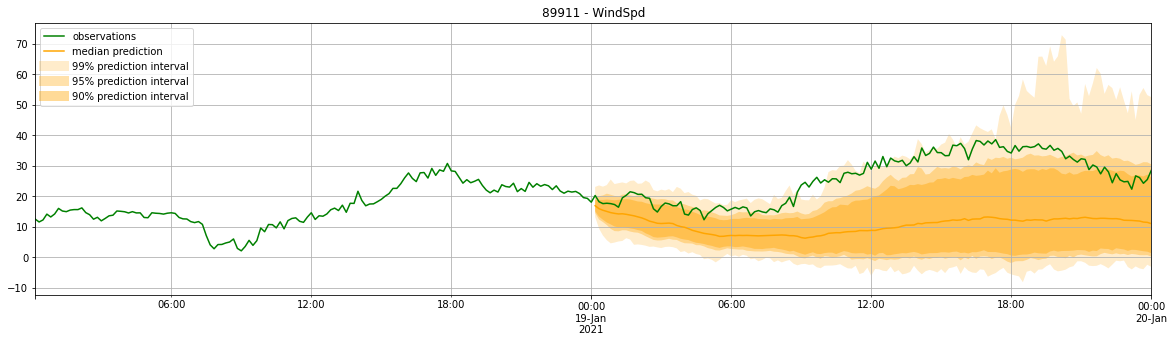

In [39]:
plot_length = 2*6*24
prediction_intervals = [90,95,99]
legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

fig, ax = plt.subplots(1, 1, figsize=(20, 5))

i = 1
stss[i][-plot_length:].plot(ax=ax, color="green")  # plot the time series
sforecasts[i].plot(prediction_intervals=prediction_intervals, color='orange')

# plt.ylim(0,40)
plt.title("{} - {}".format(test_station_id, wr_ts_columns[i]))
plt.grid(which="both")
plt.legend(legend, loc="upper left")
# plt.savefig("../images/204_wind_3day.png")
plt.show()

### Gluon-ts Metrics

In [68]:
all_single_test_datasets = []
excluded = 0
for (station_id, df) in wr_gts.groupby("Id"):
    tss = df[wr_ts_columns].transpose().iterrows()
    for (c, ts) in tss:
        all_single_test_datasets.append({
            "item_id": "Training:  {} - {}".format(station_id, c),
            "start": ts.index[0],
            "target": ts.loc[:testing_time_cutoff],
            "feat_static_cat": [station_id],
            "feat_static_real": [df[wr_cat_real_columns[0]].unique()[0], df[wr_cat_real_columns[1]].unique()[0]] #lat, long
        })

In [70]:
all_single_test_data = ListDataset(
    all_single_test_datasets,
    freq = "10min",
)

In [71]:
forecast_all_it, ts_all_it = make_evaluation_predictions(
    dataset=all_single_test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=1,  # number of sample paths we want for evaluation
)

In [ ]:
evaluator = Evaluator(quantiles=[.90, 0.99])
agg_metrics, item_metrics = evaluator(ts_all_it, forecast_all_it, num_series=len(all_single_test_data))

Running evaluation:  20%|█▉        | 417/2097 [07:30<27:35,  1.01it/s] 

In [50]:
# print(json.dumps(agg_metrics, indent=4))
agg_metrics

{'MSE': 522.8333846346067,
 'abs_error': 4363042.639350891,
 'abs_target_sum': 6282783.494140625,
 'abs_target_mean': 20.74810807226836,
 'seasonal_error': 1.135756196301695,
 'MASE': inf,
 'MAPE': 0.7546125298992681,
 'sMAPE': 0.8930102766236074,
 'OWA': nan,
 'MSIS': inf,
 'QuantileLoss[0.9]': 5080622.458879683,
 'Coverage[0.9]': 0.4199208670713161,
 'QuantileLoss[0.99]': 3153661.429187824,
 'Coverage[0.99]': 0.6459445959594138,
 'RMSE': 22.86555017126434,
 'NRMSE': 1.1020547074278124,
 'ND': 0.6944442130498211,
 'wQuantileLoss[0.9]': 0.8086578924163013,
 'wQuantileLoss[0.99]': 0.5019529054485093,
 'mean_absolute_QuantileLoss': 4117141.9440337536,
 'mean_wQuantileLoss': 0.6553053989324054,
 'MAE_Coverage': 0.41206726848463504}

In [264]:
# print(json.dumps(agg_metrics, indent=4))
agg_metrics

{'MSE': 805.3141598700454,
 'abs_error': 4722839.087440491,
 'abs_target_sum': 6268383.474243164,
 'abs_target_mean': 20.759785950311656,
 'seasonal_error': 5.3420862295385945,
 'MASE': inf,
 'MAPE': 1.4263560428505433,
 'sMAPE': 0.6411585669733381,
 'MSIS': inf,
 'QuantileLoss[0.9]': 2220044.9880833323,
 'Coverage[0.9]': 0.8135463112857882,
 'QuantileLoss[0.99]': 569466.5082951118,
 'Coverage[0.99]': 0.9104557663238071,
 'RMSE': 28.378057718421207,
 'NRMSE': 1.366972558693226,
 'ND': 0.7534381243340764,
 'wQuantileLoss[0.9]': 0.3541654714019195,
 'wQuantileLoss[0.99]': 0.0908474267145675,
 'mean_absolute_QuantileLoss': 1394755.748189222,
 'mean_wQuantileLoss': 0.22250644905824352,
 'MAE_Coverage': 0.08299896119520234,
 'OWA': nan}